In [1]:
import cv2
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from loguru import logger 
import rioxarray as rxr
import natsort

import warnings
warnings.filterwarnings("ignore")

In [2]:
images_train_path = "/home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train"
images_train = natsort.natsorted(glob.glob(os.path.join(images_train_path, "*.tif"), recursive=False))
print("IMAGES {} ### Total:  {}".format(images_train_path, len(images_train)))

df = pd.read_csv("/home/sebastien/Documents/projects/solafune-finding-mining-sites/data/answer.csv", header=None)
df.columns = ['file','target']
print("Target ### Total:  {}".format(len(df)))

IMAGES /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train ### Total:  1242
Target ### Total:  1242


In [3]:
df_train = pd.DataFrame()
df_train['image_path'] = images_train
df_train['target'] = df['target']
df_train['dataset']  = 'solafune'

In [4]:
df_train.head()

image_path  target   dataset
0  /home/sebastien/Documents/projects/solafune-fi...       0  solafune
1  /home/sebastien/Documents/projects/solafune-fi...       0  solafune
2  /home/sebastien/Documents/projects/solafune-fi...       0  solafune
3  /home/sebastien/Documents/projects/solafune-fi...       1  solafune
4  /home/sebastien/Documents/projects/solafune-fi...       0  solafune

In [5]:
df_train, df_val = train_test_split(df_train, test_size=0.10, random_state=42)
# df_val, df_test  = train_test_split(df_val, test_size=0.20, random_state=42)

In [6]:
print("train data: {}".format(len(df_train)))
print("val data: {}".format(len(df_val)))
print("test data: {}".format(len(df_test)))


train data: 1117
val data: 125


NameError: name 'df_test' is not defined

In [59]:
df_train.to_csv("../data_splits/train_path.csv")
df_test.to_csv("../data_splits/test_path.csv")
df_val.to_csv("../data_splits/valid_path.csv")

# Data exploration

In [8]:
data = rxr.open_rasterio(df_train['image_path'].iloc[-1], masked=False)
data

<xarray.DataArray (band: 12, y: 512, x: 512)>
[3145728 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * x            (x) float64 2.5 3.5 4.5 5.5 6.5 ... 510.5 511.5 512.5 513.5
  * y            (y) float64 2.5 3.5 4.5 5.5 6.5 ... 510.5 511.5 512.5 513.5
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B...

In [9]:
image = data.values
print(image.shape)

(12, 512, 512)


In [10]:
image.max()

0.7943

# Creating raw RGB composite

In [11]:
# RED -> Band 4 
# Green -> Band 3
# Blue -> Band 2 

red = image[3,:,:]
green = image[2,:,:]
blue = image[1,:,:]

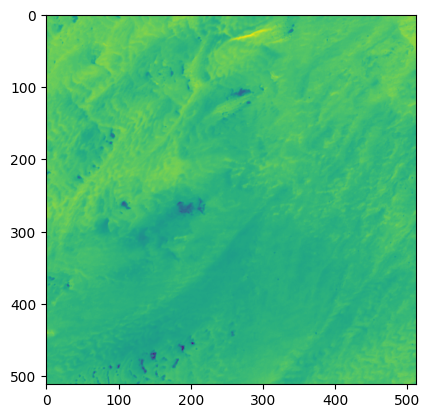

In [12]:
plt.imshow(red)

The blueish image is basically an intensity map, where each pixel represents the amount of reflected light that the Sentinel-2's sensor captured in the red band. The brighter pixels (higher values) represent more red content and the darker pixels (lower values) represent less red content.

We can change the blueish representation with the 'cmap' command. In the example below I choose 'Reds' representation.
(Note there are many other options as well. For more details please look ath the Matplotlib documentation).

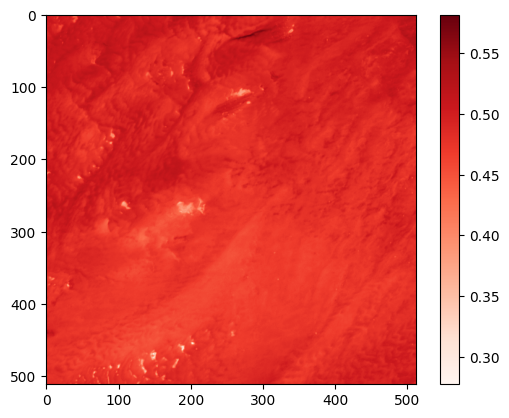

In [13]:
plt.imshow(red, cmap='Reds')
plt.colorbar()

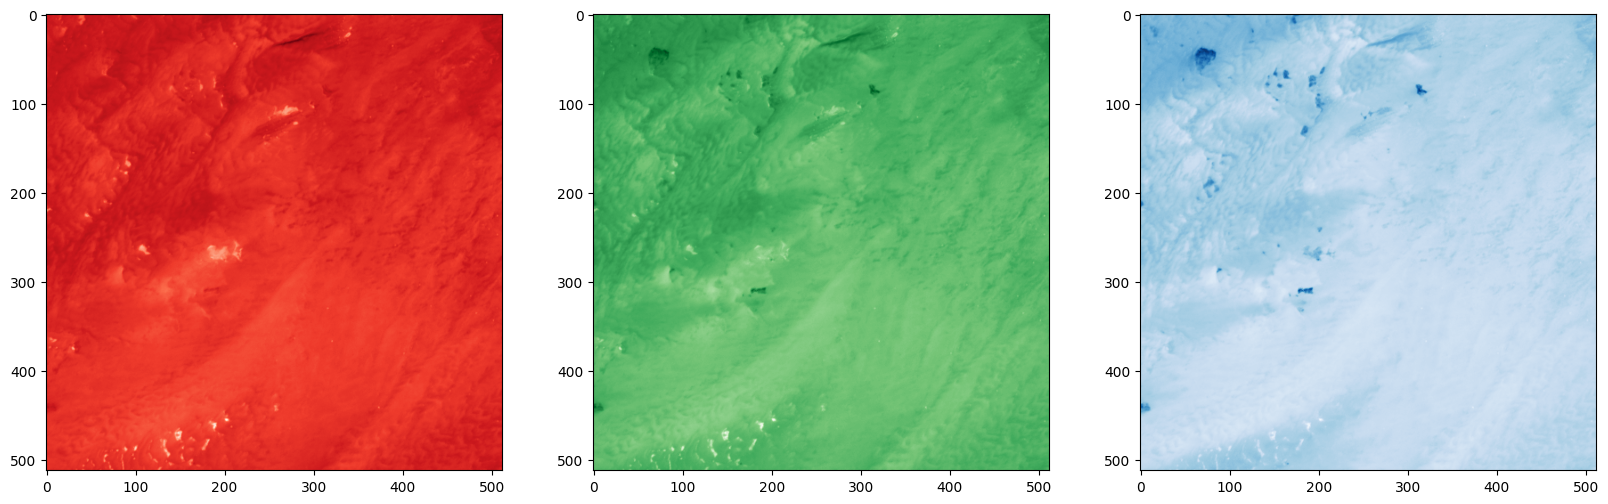

In [14]:
fig = plt.figure(figsize=(20,6))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(red, cmap='Reds')
ax1 = fig.add_subplot(1,3,2)
ax1.imshow(green, cmap='Greens')
ax1 = fig.add_subplot(1,3,3)
ax1.imshow(blue, cmap='Blues')

To make an RGB composite we have to stack together the Red, Green and Blue band images into one image with the np.dstack command.
If we call again the shape command on the newly created RGB composite we will see, that now we got a 3D array with the red,green and blue channels.

In [15]:
rgb_composite_raw= np.dstack((red, green, blue))
rgb_composite_raw.shape

(512, 512, 3)

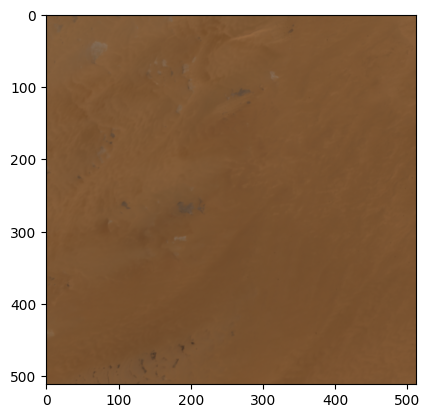

In [16]:
plt.imshow(rgb_composite_raw)

This is not quite what we are looking for, right? The root of the problem is that most images have a pixel value range from 0-255 or 0-1. If we look at the red band's max pixel value we get more than 255.

In [17]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))

red_n = normalize(red)
green_n = normalize(green)
blue_n = normalize(blue)

In [18]:
red_n.max(), green_n.max(), blue_n.max()

(1.0, 1.0, 1.0)

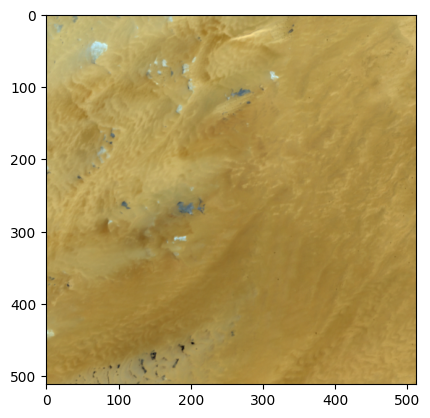

In [19]:
rgb_composite_n= np.dstack((red_n, green_n, blue_n))
plt.imshow(rgb_composite_n)

## Basic image manipulation techniques
To solve this issue, we will have to brighten each band first, then normalize them and do the stacking.
From mathematical point of view, the brightening function multiplies each pixel value with 'alpha' and adds 'beta' value if necessary.
If this operation is done we have to clip the resulted pixel values between 0..255.

In [20]:
def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0,255)

red_b=brighten(red)
blue_b=brighten(blue)
green_b=brighten(green)

red_bn = normalize(red_b)
green_bn = normalize(green_b)
blue_bn = normalize(blue_b)

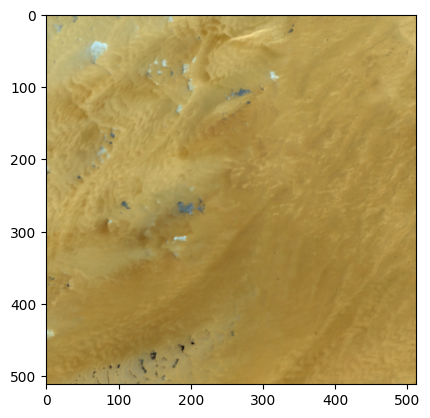

In [21]:
rgb_composite_bn= np.dstack((red_bn, green_bn, blue_bn))
plt.imshow(rgb_composite_bn)

In [22]:
rgb_composite_bn

array([[[0.7144643 , 0.6727748 , 0.42948368],
        [0.7224872 , 0.6637579 , 0.42526013],
        [0.727485  , 0.6736474 , 0.42458442],
        ...,
        [0.821743  , 0.7249854 , 0.4539803 ],
        [0.8252502 , 0.72774863, 0.44975677],
        [0.81922215, 0.7321115 , 0.44553322]],

       [[0.72836185, 0.6780104 , 0.43505877],
        [0.7222242 , 0.66816247, 0.4291796 ],
        [0.7288002 , 0.6729494 , 0.42999053],
        ...,
        [0.83704334, 0.73931056, 0.4553318 ],
        [0.8234965 , 0.7280977 , 0.43860653],
        [0.8188933 , 0.71931344, 0.43953577]],

       [[0.7330089 , 0.6891049 , 0.42970094],
        [0.73537636, 0.678883  , 0.43475473],
        [0.7327459 , 0.678592  , 0.43733948],
        ...,
        [0.8287575 , 0.7364747 , 0.4428301 ],
        [0.821129  , 0.72044057, 0.436782  ],
        [0.8195508 , 0.7233857 , 0.4340451 ]],

       ...,

       [[0.6755336 , 0.5660994 , 0.26983374],
        [0.67142355, 0.55846417, 0.2657792 ],
        [0.6653405 , 0

Now our image is looking quite realistic now. Note that this image does not represent the real reflectance values.
Another image manipulation technique is gamma correction. The math behind it is that we take each pixels intesnity values and raise it to the power of (1/gamma) where the gamma value is specified by us.
Let's use our raw images, do the gamma correction and normalization.

In [23]:
def gammacorr(band):
    gamma=2
    return np.power(band, 1/gamma)

red_g=gammacorr(red)
blue_g=gammacorr(blue)
green_g=gammacorr(green)

red_gn = normalize(red_g)
green_gn = normalize(green_g)
blue_gn = normalize(blue_g)

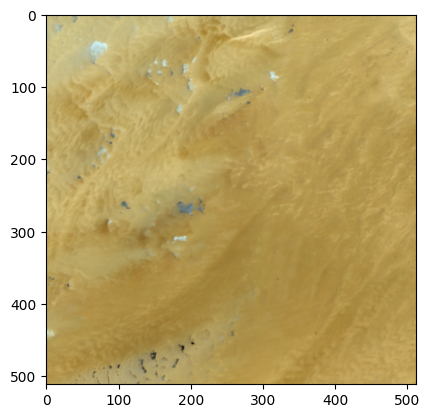

In [24]:
rgb_composite_gn= np.dstack((red_gn, green_gn, blue_gn))
plt.imshow(rgb_composite_gn)

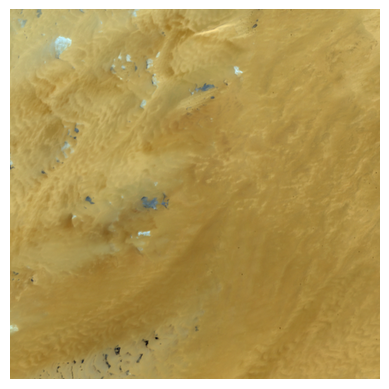

In [25]:
rgb_plot=plt.imshow(rgb_composite_bn, interpolation='lanczos')
plt.axis('off')
# plt.savefig('tihany_rgb_composite.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close('all')

In [26]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band-band_min)/((band_max - band_min)))


def image_preprocessing(image_path):

    image = rxr.open_rasterio(image_path, masked=False).values
    red = image[3,:,:]
    green = image[2,:,:]
    blue = image[1,:,:]
    red_n = normalize(red)
    green_n = normalize(green)
    blue_n = normalize(blue)
    rgb_composite_n= np.dstack((red_n, green_n, blue_n))
    return rgb_composite_n


def visualization(df,choice):
    
    random_choice = int(random.choice(np.arange(0,len(df),1)))

    image_path = df['image_path'].iloc[random_choice]
    image = rxr.open_rasterio(image_path, masked=False).values

    
    red = image[3,:,:]
    green = image[2,:,:]
    blue = image[1,:,:]
    
    red_n = normalize(red)
    green_n = normalize(green)
    blue_n = normalize(blue)
    rgb_composite_n= np.dstack((red_n, green_n, blue_n))

    print("image path {}".format(image_path))
    print("image {}".format(rgb_composite_n.shape))

    
    
    # Create a figure with subplots to display the images
    plt.figure(figsize=(15, 5))
    
    # Display the images
    plt.imshow(rgb_composite_n)
    plt.axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()
    

image path /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_193.tif
image (512, 512, 3)


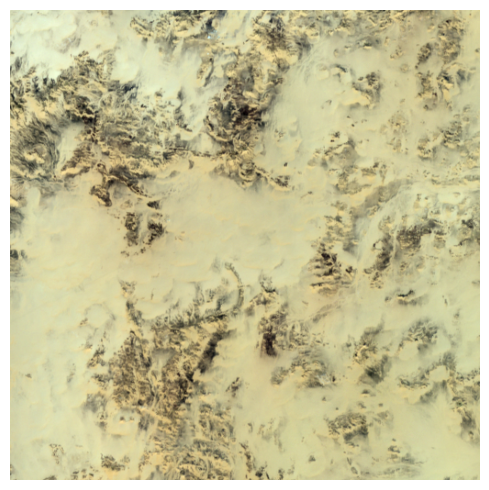

In [37]:
visualization(df_train,choice=19)

In [29]:
import cv2 


for c in range(len(df_train)):


    image_path = df_train['image_path'].iloc[c]

    tail, head = os.path.split(image_path)

    filename = os.path.join("/home/sebastien/Documents/projects/solafune-finding-mining-sites/explore",head.replace(".tif",".png"))
    
    # image_path = df_train['image_path'].iloc[c]
    image = rxr.open_rasterio(image_path, masked=False).values
    red = image[3,:,:]
    green = image[2,:,:]
    blue = image[1,:,:]
    red_n = normalize(red)
    green_n = normalize(green)

    blue_n = normalize(blue)
    rgb_composite_n= np.dstack((red_n, green_n, blue_n))

    rgb_composite_n = ((rgb_composite_n - image.min()) / (rgb_composite_n.max() - rgb_composite_n.min())) * 255
    rgb_composite_n = rgb_composite_n.astype(np.uint8)
    cv2.imwrite(filename, rgb_composite_n)
    # plt.imshow(rgb_composite_n)
    # plt.show()
    

KeyboardInterrupt: 

In [14]:
df_train

image_path  target   dataset
887   /home/sebastien/Documents/projects/solafune-fi...       1  solafune
1177  /home/sebastien/Documents/projects/solafune-fi...       0  solafune
398   /home/sebastien/Documents/projects/solafune-fi...       0  solafune
712   /home/sebastien/Documents/projects/solafune-fi...       0  solafune
793   /home/sebastien/Documents/projects/solafune-fi...       0  solafune
...                                                 ...     ...       ...
1044  /home/sebastien/Documents/projects/solafune-fi...       0  solafune
1095  /home/sebastien/Documents/projects/solafune-fi...       0  solafune
1130  /home/sebastien/Documents/projects/solafune-fi...       0  solafune
860   /home/sebastien/Documents/projects/solafune-fi...       1  solafune
1126  /home/sebastien/Documents/projects/solafune-fi...       0  solafune

[869 rows x 3 columns]

## Moisture index 

In [51]:
def moisture_visualization(df):

    import matplotlib as mpl


    
    random_choice = int(random.choice(np.arange(0,len(df),1)))

    image_path = df['image_path'].iloc[random_choice]
    image = rxr.open_rasterio(image_path, masked=False).values
    

    
    red = image[3,:,:]
    green = image[2,:,:]
    blue = image[1,:,:]
    
    red_n = normalize(red)
    green_n = normalize(green)
    blue_n = normalize(blue)
    rgb_composite_n= np.dstack((red_n, green_n, blue_n))
    
    print("image path {}".format(image_path))
    print("image {}".format(rgb_composite_n.shape))

    
    msi = image[10,:,:]/image[7,:,:]
    msi = normalize(msi)
    # Create a figure with subplots to display the images
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Display the images
    axes[0].imshow(rgb_composite_n)
    axes[0].set_title('RGB Image')
    axes[0].axis('off')
    
    
    axes[1].imshow(msi,cmap=mpl.colormaps["YlGn_r"])
    axes[1].set_title('msi')
    axes[1].axis('off')

    
    # Show the plot
    plt.tight_layout()
    plt.show()

image path /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_3.tif
image (512, 512, 3)


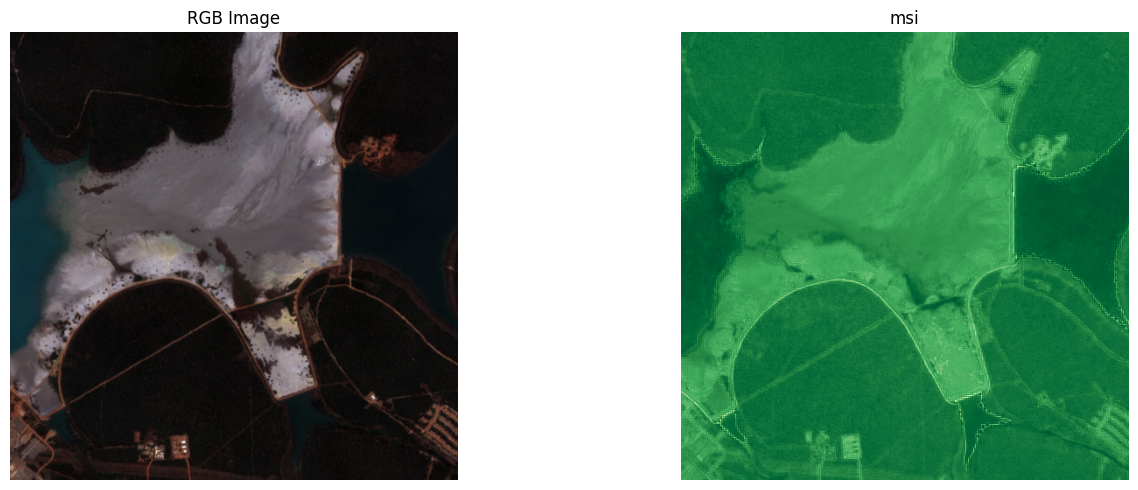

In [53]:
moisture_visualization(df_val)

In [54]:
def ndvi_visualization(df):

    import matplotlib as mpl


    
    random_choice = int(random.choice(np.arange(0,len(df),1)))

    image_path = df['image_path'].iloc[random_choice]
    image = rxr.open_rasterio(image_path, masked=False).values
    
    red = image[3,:,:]
    green = image[2,:,:]
    blue = image[1,:,:]
    
    red_n = normalize(red)
    green_n = normalize(green)
    blue_n = normalize(blue)
    rgb_composite_n= np.dstack((red_n, green_n, blue_n))
    
    print("image path {}".format(image_path))
    print("image {}".format(rgb_composite_n.shape))
    
    NDWI = image[2,:,:]-image[7,:,:]/image[2,:,:]+image[7,:,:]
    NDWI = normalize(NDWI)
    # Create a figure with subplots to display the images
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Display the images
    axes[0].imshow(rgb_composite_n)
    axes[0].set_title('RGB Image')
    axes[0].axis('off')
    
    
    axes[1].imshow(NDWI,cmap=mpl.colormaps["YlGn"])
    axes[1].set_title('NDWI')
    axes[1].axis('off')

    
    # Show the plot
    plt.tight_layout()
    plt.show()

image path /home/sebastien/Documents/projects/solafune-finding-mining-sites/data/train/train_316.tif
image (512, 512, 3)


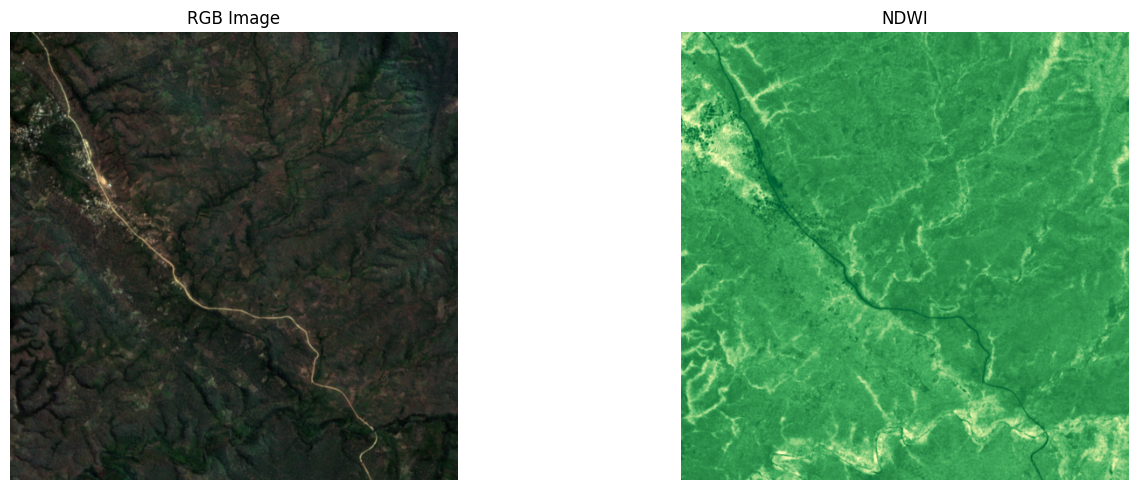

In [57]:
ndvi_visualization(df_train)

Values description: Index values greater than 0.5 usually correspond to water bodies. Vegetation usually corresponds to much smaller values and built-up areas to values between zero and 0.2.



##  Classes distribution

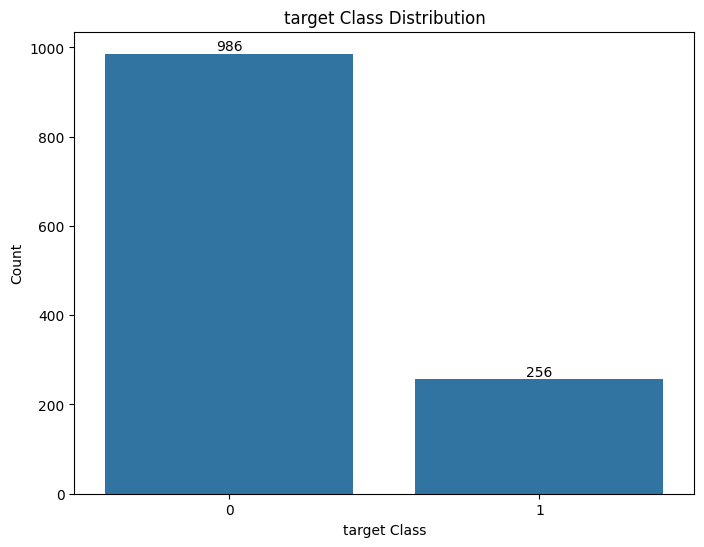

In [58]:
import seaborn as sns 

class DatasetAnalyzer:
    def __init__(self, df):
        
        self.df = df
        
    def check_target_balance(self, column, verbose):
        """
        Check if the dataset is balanced or unbalanced based on the specified column.

        Args:
        - column (str): The column name for which balance is checked.
        - verbose (bool): Whether to display the bar plot. Defaults to True.

        Returns:
        - pandas.DataFrame: DataFrame displaying counts and percentages.
        """
        column_value_counts = self.df[column].value_counts()
        column_percentage = column_value_counts / len(self.df[column]) * 100

        result_df = pd.DataFrame({'Count': column_value_counts, 'Percentage': column_percentage})
        result_df.index.name = f'{column} Values'

        if  verbose:
            plt.figure(figsize=(8, 6))
            ax = sns.barplot(x=result_df.index, y='Count', data=result_df.reset_index())
            plt.title(f'{column} Class Distribution')
            plt.xlabel(f'{column} Class')
            plt.ylabel('Count')

            for p in ax.patches:
                ax.annotate(format(p.get_height(), '.0f'),
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center',
                            xytext=(0, 5),
                            textcoords='offset points')

            plt.show()

        return result_df

    def check_dtypes_balance(self, verbose):
        """
        Plot data type counts of columns in a DataFrame using a bar plot.

        Returns:
        - None (displays the bar plot).
        """
        data_types = self.df.dtypes
        data_type_counts = data_types.value_counts().reset_index()
        data_type_counts.columns = ['Data Type', 'Count']

        plt.figure(figsize=(8, 6))
        ax = sns.barplot(x='Data Type', y='Count', data=data_type_counts)

        plt.title('Data Types of Columns')
        plt.xlabel('Data Types')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        if verbose:
            for p in ax.patches:
                ax.annotate(format(p.get_height(), '.0f'),
                            (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center',
                            xytext=(0, 5),
                            textcoords='offset points')

        plt.show()
        return data_type_counts
    
    def visualize_missing_values(self):
        """
        Visualize missing values in the DataFrame using a bar plot.

        Args:
        - df (pandas.DataFrame): The DataFrame to check for missing values.

        Returns:
        - None: Displays a bar plot showing the count of missing values in columns.
        """
        # Calculate percentage of missing values in the DataFrame
        missing_values = self.df.isnull().sum().sort_values(ascending=False)
        missing_values = missing_values[missing_values > 0]  # Select columns with missing values
        total_entries = len(self.df)  # Total number of entries in the DataFrame

        # Calculate percentage of missing values relative to the total dataset
        missing_values_percentage = (missing_values / total_entries) * 100

        # Plotting missing values as a percentage using Seaborn bar plot
        plt.figure(figsize=(10, 6))
        sns.barplot(x=missing_values_percentage.index, y=missing_values_percentage.values)

        plt.title('Percentage of Missing Values in Columns')
        plt.xlabel('')  # Empty x-label to remove x-axis labels
        plt.ylabel('Percentage of Missing Values')
        plt.xticks([])  # Remove x-axis ticks and labels
        plt.tight_layout()
        plt.show()


da = DatasetAnalyzer(df)
result = da.check_target_balance(column='target',verbose=True)

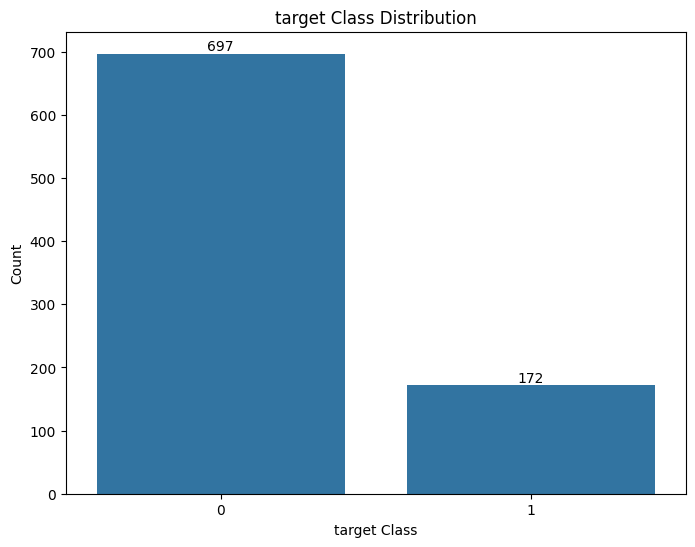

In [59]:
da = DatasetAnalyzer(df=df_train)
result = da.check_target_balance(column='target',verbose=True)

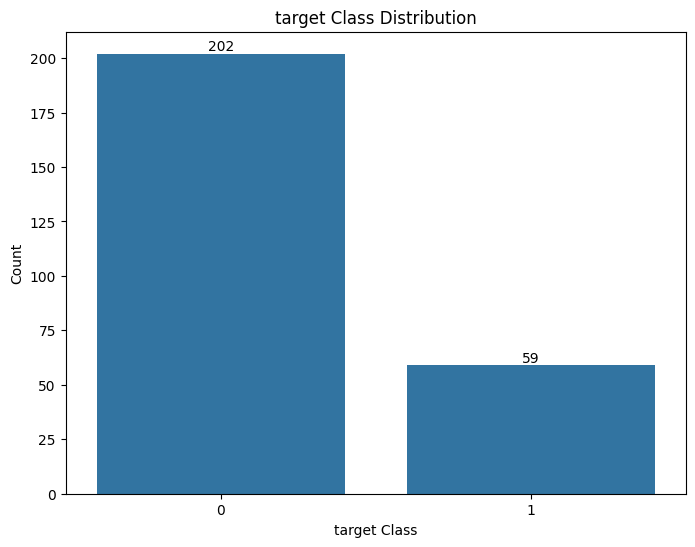

In [39]:
da = DatasetAnalyzer(df=df_test)
result = da.check_target_balance(column='target',verbose=True)

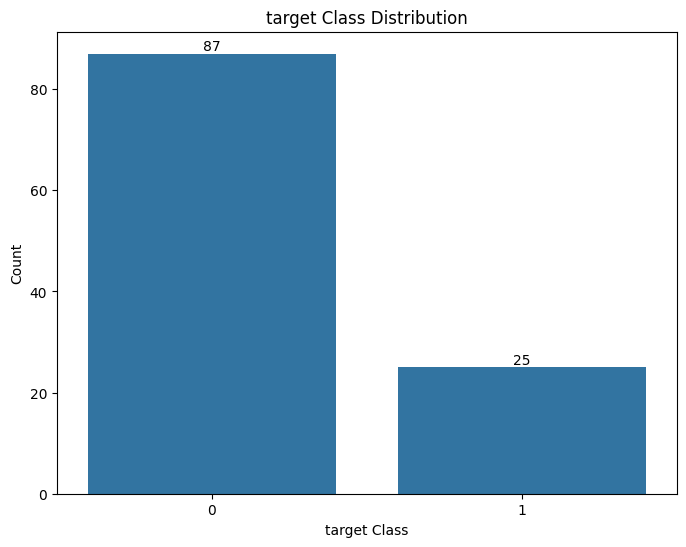

In [40]:
da = DatasetAnalyzer(df=df_val)
result = da.check_target_balance(column='target',verbose=True)

In [25]:
## Proprocessing

In [27]:
image.shape

(12, 512, 512)

In [3]:
from torchvision.models import resnet50, ResNet50_Weights

In [7]:


from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

img = read_image("dog.jpg")

# Step 1: Initialize model with the best available weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

# Step 4: Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

golden retriever: 55.9%


/home/sebastien/miniconda3/envs/solafune/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [14]:
from torch import nn

In [19]:
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

In [20]:
model.fc = nn.Linear(model.fc.in_features, 2)

In [21]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = preprocess(img).unsqueeze(0)

# Step 4: Use the model and print the predicted category
prediction = model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

goldfish: 52.9%


In [31]:
import torch
images_inputs = torch.load("images_inputs.pt")
images_inputs.shape

torch.Size([4, 3, 512, 512])

In [32]:
targets = torch.load("targets.pt")
targets.shape

torch.Size([4])

In [34]:
 preds = model(images_inputs)
 preds.shape

torch.Size([4, 2])

In [39]:
from torch.nn import functional as F
preds = F.softmax(preds, dim=1)
preds.shape

torch.Size([4, 2])

In [40]:
preds

tensor([[0.5256, 0.4744],
        [0.5236, 0.4764],
        [0.5043, 0.4957],
        [0.4818, 0.5182]], grad_fn=<SoftmaxBackward0>)

In [43]:
preds = torch.argmax(preds, dim=1)
preds 

tensor([0, 0, 0, 1])

In [44]:
targets

tensor([0, 0, 0, 0])

In [45]:
criterion = nn.BCELoss()

In [46]:
loss_train = criterion(preds.to(torch.float32), targets.to(torch.float32))

In [47]:
loss_train

tensor(25.)

In [48]:
targets = torch.unsqueeze(targets, 1)
preds = torch.unsqueeze(preds, 1)


In [49]:
loss_train = criterion(preds.to(torch.float32), targets.to(torch.float32))

In [50]:
loss_train

tensor(25.)